# Objective
Given OFDM signal, we want to find at which point in time the OFDM symbols are located or we can say, which signal part the receiver needs to perform the FFT?

# System Model and Frame Structure

The received signal $y(t)$ is modeled as a delayed and noisy version of transmitted signal $x(t)$.
$$ y(t) = x(t-\tau) + n(t) $$

where $\tau$ is the delay and $n(t)$ is AWGN. $\tau$ is unknown at the receiver and needs to be estimated.

Schmidl and Cox came up with a way to sync up data in an OFDM system. They use a special pattern called a "preamble" that has a specific shape. It is made up of two parts that are repeated and there's a bit added to the start called a "cyclic prefix". In this project, I'll follow their method, and use a particular setup for organizing data, which shown in the figure below.

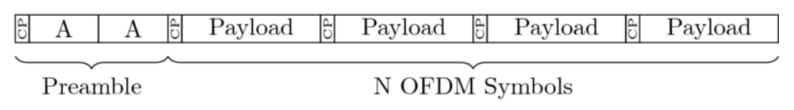

In [2]:
import numpy as np
import scipy
import scipy.signal as signal
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
img = plt.imread('ofdm_frame.png')
plt.imshow(img)
plt.axis('off')
plt.show()

Every frame begins with a preamble that has two identical parts, labeled as A. After that, there will be N OFDM symbols carrying the actual data payload. Preamble can contain information, the only criterion is that this part is repeated twice.

## Modeling the received signal

In [3]:
class OFDM:
    def __init__(self):
        self.K = 1024                      # Number of OFDM subcarriers
        self.Kon = 600                     # Number of switched-on subcarriers
        self.CP = 128                      # Number of samples in the CP
        self.ofdmSymbolsPerFrame = 5       # N, number of payload symbols in each frame
        self.L = self.K // 2               # Parameter L, denotes the length of one repeated part of the preamble

ofdm = OFDM()

### Generating random QAM symbols and perform OFDM modulation and CP insertion

In [4]:
def random_QAM(ofdm):
    qam = np.array([1+1j, 1-1j, -1+1j, -1-1j])/np.sqrt(2)        # Generate random QAM symbols
    return np.random.choice(qam, size=(ofdm.Kon), replace=True)

def ofdm_modulate(ofdm, qam):
    assert (len(qam) == ofdm.Kon)                   
    fd_data = np.zeros(ofdm.K, dtype=complex)       # Initialize frequency-domain OFDM symbol
    off = (ofdm.K - ofdm.Kon) // 2                  # Calculate modulation offset
    fd_data[off:(off + len(qam))] = qam             # Modulate QAM symbols into the frequency-domain OFDM symbol
    fd_data = np.fft.fftshift(fd_data)              # Shift frequency-domain OFDM symbol to the center
    symbol = np.fft.ifft(fd_data) * np.sqrt(ofdm.K) # Transform frequency-domain to time-domain OFDM symbol
    return np.hstack([symbol[-ofdm.CP:], symbol])   # Add cyclic prefix and concatenate with the original symbol


### Generating preamble

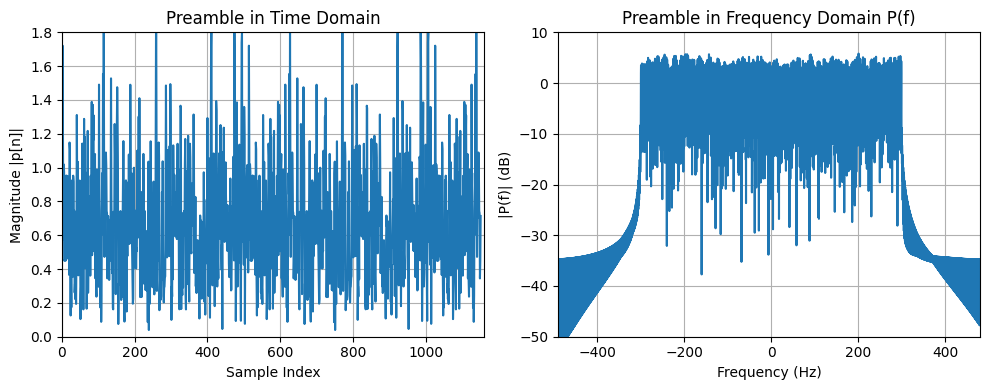

In [40]:
qam_preamble = np.sqrt(2)*random_QAM(ofdm)
qam_preamble[::2] = 0     # delete every second data to make the preamble 2-periodic

preamble = ofdm_modulate(ofdm, qam_preamble)

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(abs(preamble))
plt.axis([0, 1160, 0, 1.8])
plt.title('Preamble in Time Domain')
plt.xlabel('Sample Index')
plt.ylabel('Magnitude |p[n]|')
plt.grid(True)


plt.subplot(122)
f = np.linspace(-ofdm.K/2, ofdm.K/2, 4*len(preamble), endpoint=False)
plt.plot(f, 20*np.log10(abs(np.fft.fftshift(np.fft.fft(preamble, 4*len(preamble))/np.sqrt(len(preamble))))))
plt.axis([-490, 480, -50, 10])
plt.title('Preamble in Frequency Domain P(f)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|P(f)| (dB)')
plt.grid(True)
plt.tight_layout()
plt.show()

By specifying 4*len(preamble), we are effectively zero-padding the preamble array before computing the FFT. Zero-padding in the time domain corresponds to interpolation in the frequency domain, which can make the frequency-domain representation look smoother and more continuous, especially when plotting.

### Create one frame

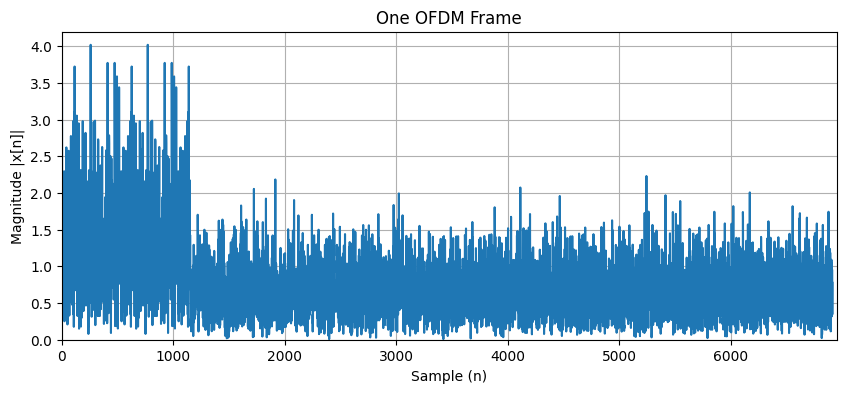

In [43]:
def createFrame(ofdm, qam_preamble=None):
    if qam_preamble is None:                        # Generate preamble if not provided
        qam_preamble = np.sqrt(2)*random_QAM(ofdm)  # Generate random QAM symbols
        qam_preamble[::2] = 0                       # delete every second data to make the preamble 2-periodic 
    preamble = ofdm_modulate(ofdm, qam_preamble)    # Modulate preamble into time-domain
    
    payload = np.hstack([ofdm_modulate(ofdm, random_QAM(ofdm)) for i in range(ofdm.ofdmSymbolsPerFrame)]) 
    return np.hstack([preamble, payload])           # Concatenate preamble and payload to form a frame  

frame = createFrame(ofdm, qam_preamble=qam_preamble*2)

plt.figure(figsize=(10, 4))
plt.plot(abs(frame))
plt.axis([0, 6950, 0, 4.2])
plt.title('One OFDM Frame')
plt.xlabel('Sample (n)')
plt.ylabel('Magnitude |x[n]|')
plt.grid(True)
plt.show()

### Now let's define channel

In [7]:
def addCFO(signal, cfo):           # Add carrier frequency offset (unused in this notebook)
    return signal*np.exp(2j*np.pi*cfo*np.arange(len(signal)))

def addSTO(signal, sto):           # add some time offset
    return np.hstack([np.zeros(sto), signal])

def addNoise(signal, sigma2):      # add AWGN
    noise = np.sqrt(sigma2/2)*(np.random.randn(len(signal)) + 1j*np.random.randn(len(signal)))
    return signal + noise

def addChannel(signal, h):         # add some multipath impulse response (unused in this notebook)
    return scipy.signal.lfilter(h, (1,), signal)

In the line scipy.signal.lfilter(h, (1,), signal), it's applying a filter to the signal array. The filter is defined by the coefficients h and (1,).

The h array contains the feed-forward (numerator) coefficients of the filter, and (1,) is the feed-back (denominator) coefficients of the filter. In this case, (1,) means that there is no feedback component in the filter, so this is a finite impulse response (FIR) filter.

The output of lfilter is the signal filtered by the FIR filter with coefficients h. This can be used to perform operations such as smoothing, prediction, or removing certain frequency components from signal.

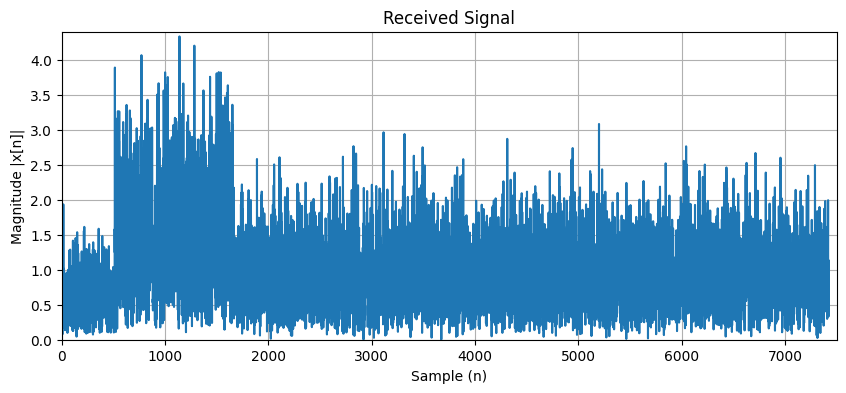

In [48]:
x = createFrame(ofdm, qam_preamble=qam_preamble*2) # Generate a frame
sto = ofdm.K//2                                    # Add some STO
r = addNoise(addSTO(x, sto), 0.5)                  # Add noise and STO

plt.figure(figsize=(10, 4))
plt.plot(abs(r))
plt.axis([0, 7500, 0, 4.4])
plt.title('Received Signal')
plt.xlabel('Sample (n)')
plt.ylabel('Magnitude |x[n]|')
plt.grid(True)
plt.show()

Now we have received signal, we can implement the proposed algorithm. The algorithm is based on a metric which is calculated from the received signal. 
When metric goes beyond a certain level, the preamble is detected.

### Calculating Metric P(d)
$$ P(d) = \sum_{m=0}^{L-1} (r[d+m] * r[d+m+L]) $$


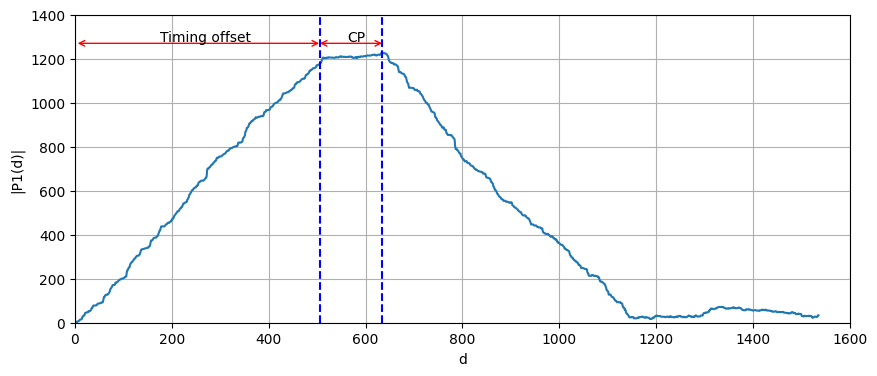

In [9]:
d_set = np.arange(0, sto + ofdm.K)
P1 = np.zeros(len(d_set), dtype=complex)
for i, d in enumerate(d_set):
    P1[i] = sum(r[d+m].conj()*r[d+m+ofdm.L] for m in range(ofdm.L))

plt.figure(figsize=(10, 4))
plt.plot(d_set, abs(P1))
plt.axis([0, 1600, 0, 1400])
plt.annotate('', xy=(0, 1270), xytext=(510, 1270), arrowprops=dict(arrowstyle='<->', color='r')) # Draw double-ended arrow
plt.annotate('', xy=(500, 1270), xytext=(640, 1270), arrowprops=dict(arrowstyle='<->', color='r'))
plt.text(270, 1280, 'Timing offset', fontsize=10, ha='center')  # Add text above the line
plt.text(580, 1280, 'CP', fontsize=10, ha='center')             # Add text above the line
plt.axvline(x=505, color='b', linestyle='--')                   # Draw vertical line
plt.axvline(x=635, color='b', linestyle='--')
plt.ylabel('|P1(d)|')
plt.xlabel('d')
plt.grid(True)
plt.show()

 Recursive method to calculate P(d)
$$P(d+1) = P(d) + r[d+L] \times r[d+2L] - r[d] \times r[d+L]$$

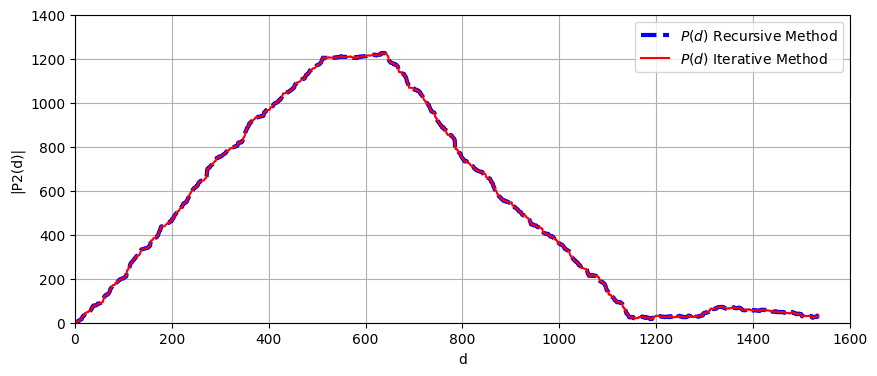

In [10]:
P0 = sum(r[m].conj()*r[m+ofdm.L] for m in range(ofdm.L))  # initialize P[0] with the default method
def calcP_method2(r, d_set, P0):
    P2 = np.zeros(len(d_set), dtype=complex)
    P2[0] = P0
    for d in d_set[:-1]:
        P2[d+1] = P2[d] + r[d+ofdm.L].conj()*r[d+2*ofdm.L] - r[d].conj()*r[d+ofdm.L]
    return P2

P2 = calcP_method2(r, d_set, P0)

plt.figure(figsize=(10, 4))
plt.plot(d_set, abs(P2), 'b--', lw=3, label='$P(d)$ Recursive Method'); 
plt.plot(d_set, abs(P1), 'r', label='$P(d)$ Iterative Method')
plt.axis([0, 1600, 0, 1400])
plt.ylabel('|P2(d)|')
plt.xlabel('d')
plt.grid(True)
plt.legend()

Now, lets formalize the calcultion of $P(d)$. Define a signal $v[d]$
$$v[d]=r[d+L] \cdot r[d+2L]$$
Recursive method of calculation of $P[d]$ is given as $$P(d+1)=P(d)+v[d]−v[d−L]$$
Above eqution is linear IIR filter. $v[d]$ is non causal sequence so to make it causal, we introduce a delay of 2L samples to $r[d]$ which gives $\bar{r}[n]=r[n-2L]$.
Again define $$\bar{v}[d]=\bar{r}[d+L] \cdot \bar{r}[d+2L]=r[d-L] \cdot r[d]$$ 
The causal version of $p(d)$ is given as  $$\bar{P}(d+1)=\bar{P}(d)+\bar{v}[d]-\bar{v}[d-L]$$

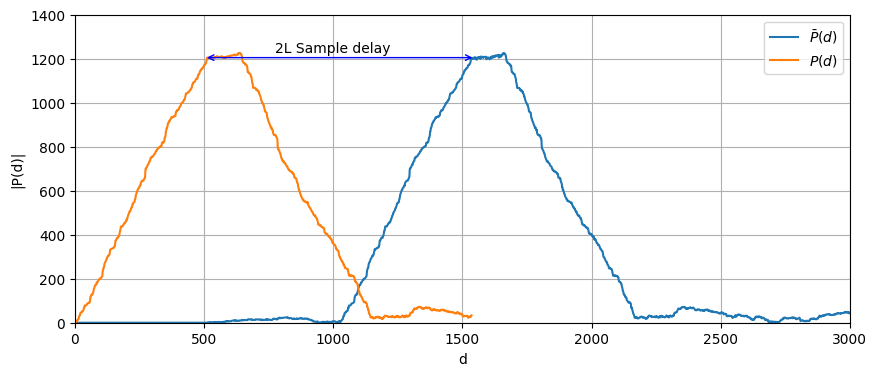

In [11]:
def calcP_method3(r):
    L = ofdm.L
    b_P = np.zeros(L)
    b_P[0] = 1; b_P[L-1] = -1
    a_P = (1, -1)
    
    # Implements r[d-L] * r[d], assuming r[d<0] = 0
    v_bar = np.hstack([np.zeros(L), r[L:].conj() * r[:-L]]) 
    P_bar = scipy.signal.lfilter(b_P, a_P, v_bar)
    return P_bar

P_bar = calcP_method3(r)

plt.figure(figsize=(10, 4))
plt.plot(abs(P_bar), label='$\\bar{P}(d)$')
plt.plot(abs(P1), label='$P(d)$')
plt.axis([0, 3000, 0, 1400])
plt.annotate('', xy=(500, 1205), xytext=(1550, 1205), arrowprops=dict(arrowstyle='<->', color='b'))
plt.text(1000, 1230, '2L Sample delay', fontsize=10, ha='center')
plt.ylabel('|P(d)|')
plt.xlabel('d')
plt.grid(True)
plt.legend()

The impulse responce of the above IIR filter is given as follows:

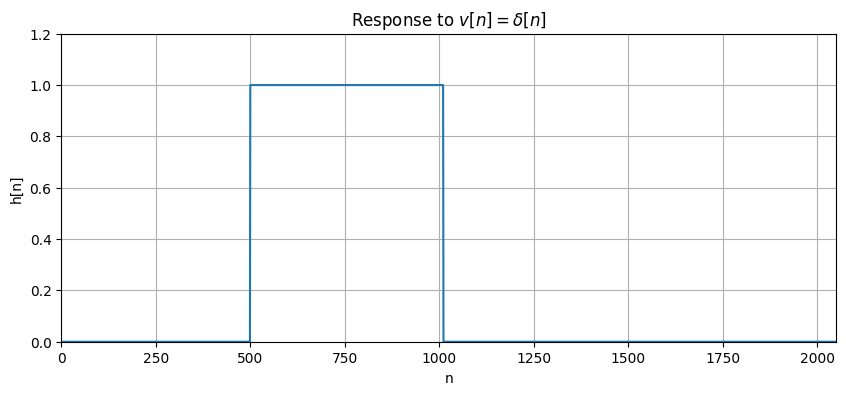

In [12]:
b = np.zeros(ofdm.L)
b[0] = 1
b[ofdm.L-1] = -1
a = (1,-1)
imp_resp = np.zeros(4*ofdm.L)
imp_resp[500] = 1

plt.figure(figsize=(10, 4))
x_ax = np.arange(len(imp_resp))
y_ax = scipy.signal.lfilter(b, a, imp_resp)
plt.plot(x_ax, y_ax)
plt.axis([0, 2050, 0, 1.2])
plt.title('Response to $v[n]=\delta[n]$')
plt.ylabel('h[n]')
plt.xlabel('n')
plt.grid(True)
plt.show()

The impulse response of the filter is a rect function of width of L samples. The input signal $x[n]$ and output signals $y[n]$ are related as: 
\begin{align*}
    y[n] &= y[n-1] + x[n] - x[n-L] \\
    Y(z)(1-z^{-1}) &= X(z)(1-z^{-L}) \\
    \frac{Y(z)}{X(z)} &= \frac{1 - z^{-L}}{1 - z^{-1}} \\
    &= \frac{(1 - z^{-1})(1 + z^{-1} + z^{-2} + \ldots + z^{-(L-1)})}{1 - z^{-1}}\\
    &= 1 + z^{-1} + z^{-2} + \ldots + z^{-(L-1)}
\end{align*}

### Calculating Metric R(d)

R(d) is also called as receive energy given by, 
$$R(d) = \sum_{m=0}^{L-1} |r[d+m+L]|^2$$
which can be further simplified to non-causal version as follows,
$$R(d+1) = R(d) + |r[d+2L]|^2 - |r[d+L]|^2$$
and corresponding causal version as, 
$$\bar{R}(d+1) = \bar{R}(d) + |r[d]|^2 - |r[d-L]|^2
$$

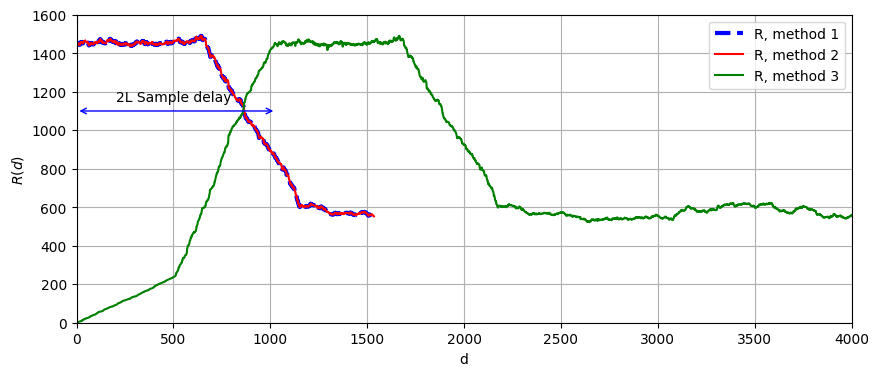

In [13]:
def calR_method1(r, d_set):       # the iterative method
    R = np.zeros(len(d_set))
    for i, d in enumerate(d_set):
        R[i] = sum(abs(r[d+m+ofdm.L])**2 for m in range(ofdm.L))
    return R

def calR_method2(r, d_set, R0):   # the non-causal recursive expression
    R = np.zeros(len(d_set))
    R[0] = R0
    for d in d_set[:-1]:
        R[d+1] = R[d] + abs(r[d+2*ofdm.L])**2 - abs(r[d+ofdm.L])**2
    return R

def calR_method3(r):              # IIR filter expression
    b = np.zeros(ofdm.L); b[0] = 1; b[-1] = -1
    a = (1,-1)
    return scipy.signal.lfilter(b, a, abs(r)**2)

R1 = calR_method1(r, d_set)
R2 = calR_method2(r, d_set, R1[0])
R_bar = calR_method3(r)

plt.figure(figsize=(10, 4))
plt.plot(abs(R1), 'b--', lw=3, label='R, method 1')
plt.plot(abs(R2), 'r', label='R, method 2')
plt.plot(abs(R_bar), 'g', label='R, method 3')
plt.axis([0, 4000, 0, 1600])
plt.annotate('', xy=(0, 1100), xytext=(1030, 1100), arrowprops=dict(arrowstyle='<->', color='b'))
plt.text(500, 1150, '2L Sample delay', fontsize=10, ha='center')
plt.ylabel('$R(d)$')
plt.xlabel('d')
plt.legend()
plt.grid(True)
plt.show()


### Metric M(d)
The final metric M(d), which is normalized value of P(d) with received energy R(d) is defined as follows,
$$M(d) = \frac{|P(d)|^2}{R(d)^2}$$

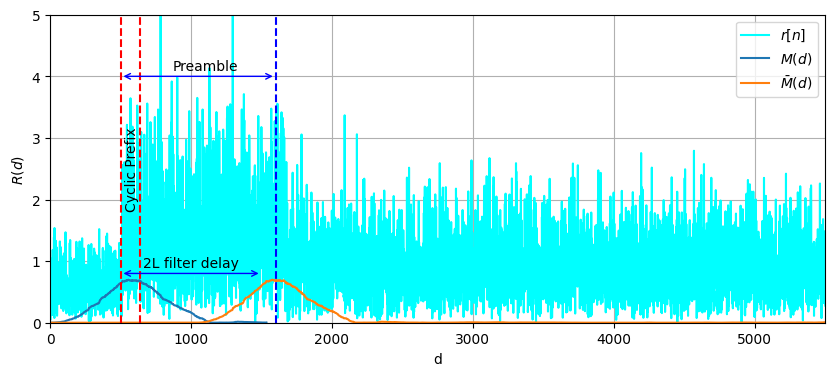

In [14]:
M = abs(P1)**2/R1**2
M_bar = abs(P_bar)**2/R_bar**2

plt.figure(figsize=(10, 4))
plt.plot(abs(r), label='$r[n]$', color='cyan')
plt.plot(M, label='$M(d)$')
plt.plot(M_bar, label='$\\bar{M}(d)$')

plt.axis([0, 5500, 0, 5])
plt.axvline(x=505, color='r', linestyle='--')                   
plt.axvline(x=635, color='r', linestyle='--')
plt.axvline(x=1605, color='b', linestyle='--')    
plt.annotate('', xy=(500, 4), xytext=(1600, 4), arrowprops=dict(arrowstyle='<->', color='b'))
plt.text(1100, 4.1, 'Preamble', fontsize=10, ha='center')        
plt.text(x=530, y=2.5, s='Cyclic Prefix', rotation=90, verticalalignment='center')  # Add vertical text between the lines
plt.annotate('', xy=(500, 0.8), xytext=(1500, 0.8), arrowprops=dict(arrowstyle='<->', color='b'))
plt.text(1000, 0.9, '2L filter delay', fontsize=10, ha='center')
plt.ylabel('$R(d)$')
plt.xlabel('d')
plt.legend()
plt.grid(True)
plt.show()


From the above figure it can be seen that $M(d)$ reaches maximum at the start of the preamle and $\bar{M}(d)$ reaches maximum after delay of 2L samples.

The distrubution of metric $M(d)$ is gaussian with mean $\mu$ and variance $\sigma^2$ given as,
$$\mu = \frac{\sigma^4_s}{(\sigma^2_s + \sigma^2_n)^2}$$
$$\sigma^2 = \frac{2\sigma^4_s \left[ (1+\mu)\sigma^2_s\sigma^2_n + (1+2\mu)\sigma^4_n \right]}{L(\sigma^2_s + \sigma^2_n)^4}$$

where $\sigma_{s}^2$ is the preamble power and $\sigma_{n}^2$ is the noise power. With the relation of the SNR $\sigma$ given by 
$$\rho = \frac{\sigma^2_s}{\sigma^2_n}, \quad \sigma^2_n = \rho \sigma^2_s$$

Function to calculate metric $\bar{M}$

In [15]:
def calP_R_M(rx_signal, L):
    rx1 = rx_signal[:-L]
    rx2 = rx_signal[L:]
    mult = rx1.conj() * rx2
    square = abs(rx1**2)
    a_P = (1, -1)
    b_P = np.zeros(L)
    b_P[0] = 1
    b_P[-1] = -1
    P = scipy.signal.lfilter(b_P, a_P, mult)/L
    R = scipy.signal.lfilter(b_P, a_P, square)/L
    Pr = P[L:]
    Rr = R[L:]
    M = abs(Pr/Rr)**2
    return Pr, Rr, M     # throw away first L samples, as they are not correct due to filter causality

Metric for different SNR

In [16]:
M_dopt = {}
M_doutside = {}
SNRs = np.linspace(-10, 30, 21)

for SNR in SNRs:
    M_dopt[SNR] = []
    M_doutside[SNR] = []
    for i in range(100):
        tx_signal = createFrame(ofdm, qam_preamble=None)
        sigma_s2 = np.mean(abs(tx_signal**2))
        sigma_n2 = sigma_s2 * 10**(-SNR/10.)
        sto = 1000
        cfo = 0.05 / ofdm.K
        rx_signal = addNoise(addCFO(addSTO(tx_signal, sto), cfo), sigma_n2)
        P, R, M = calP_R_M(rx_signal, ofdm.L)
        M_dopt[SNR].append(M[sto])
        M_doutside[SNR].append(M[sto + ofdm.K])

Evaluate the result and compare with the theoretic values.

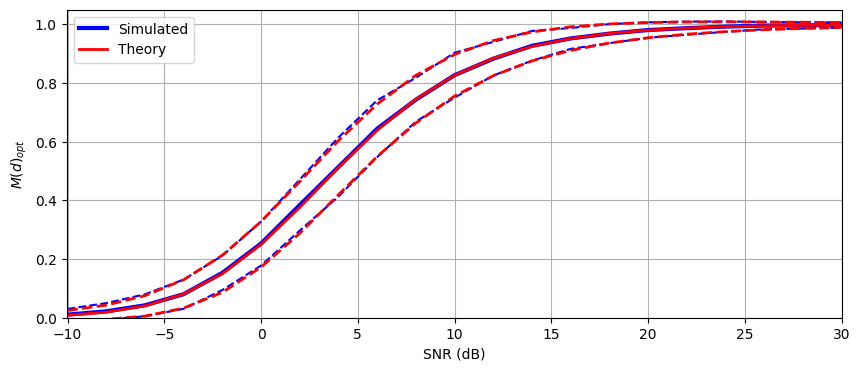

In [17]:
def calc_MeanStd(SNRs, measurement):
    mean = np.array([np.mean(measurement[SNR]) for SNR in SNRs])
    std = np.array([np.std(measurement[SNR]) for SNR in SNRs])
    return mean, std

mean_opt, std_opt = calc_MeanStd(SNRs, M_dopt)

plt.figure(figsize=(10, 4))
# Plot the measured curves
plt.plot(SNRs, mean_opt, label='Simulated', color='blue', lw=3)
plt.plot(SNRs, mean_opt+3*std_opt, 'b--')
plt.plot(SNRs, mean_opt-3*std_opt, 'b--')

# Plot the theoretic curves
rho = 10**(-SNRs/10)
mu = 1/(1+rho)**2
std = np.sqrt(2*((1+mu)*rho+(1+2*mu)*rho**2)/(ofdm.L*(1+rho)**4))

plt.plot(SNRs, mu, label='Theory', color='r', lw=2)
plt.plot(SNRs, mu + 3*std, color='r', lw=2, ls='--')
plt.plot(SNRs, mu - 3*std, color='r', lw=2, ls='--')
plt.axis([-10.05, 30, 0, 1.05])
plt.ylabel('$M(d)_{opt}$')
plt.xlabel('SNR (dB)')
plt.legend()
plt.grid(True)
plt.show()


Using $M(d)$ for synchronization

From the above figure, we can say that the simulated value and theoretic value overlap.

It's easy to notice intuitively that once M(d) surpasses a certain threshold, a preamble is detected. However, since the metric doesn't exhibit a distinct peak, but rather a plateau, additional logic is required to accurately identify the frames.

There can be an arbitrary delay between frames, which makes timing synchronization more challenging. Let's begin by generating a sample signal. To illustrate, we'll also indicate where the preamble and payload symbols are situated:


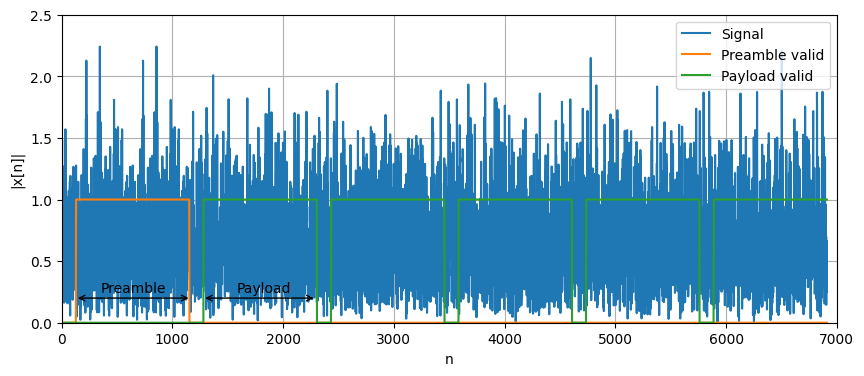

In [18]:
def createFrame_withSyncInfo(ofdm):
    qam_preamble = np.sqrt(2)*random_QAM(ofdm)
    qam_preamble[::2] = 0
    preamble = ofdm_modulate(ofdm, qam_preamble)

    payload = np.hstack([ofdm_modulate(ofdm, random_QAM(ofdm)) for _ in range(ofdm.ofdmSymbolsPerFrame)])
    
    frame = np.hstack([preamble, payload])
    preamble_valid = np.zeros(len(frame))
    payload_valid = np.zeros(len(frame))
    preamble_valid[ofdm.CP:ofdm.CP+ofdm.K] = 1
    for f in range(ofdm.ofdmSymbolsPerFrame):
        payload_valid[(ofdm.CP+ofdm.K)*(f+1) + ofdm.CP + np.arange(ofdm.K)] = 1
    
    return frame, preamble_valid, payload_valid

frame, preamble_valid, payload_valid = createFrame_withSyncInfo(ofdm)

plt.figure(figsize=(10, 4))
plt.plot(abs(frame), label='Signal')
plt.plot(preamble_valid, label='Preamble valid')
plt.plot(payload_valid, label='Payload valid')
plt.axis([0, 7000, 0, 2.5])
plt.ylabel('|x[n]|')
plt.xlabel('n')
plt.annotate('', xy=(120, 0.2), xytext=(1170, 0.2), arrowprops=dict(arrowstyle='<->'))
plt.text(650, 0.25, 'Preamble', fontsize=10, ha='center')
plt.annotate('', xy=(1270, 0.2), xytext=(2300, 0.2), arrowprops=dict(arrowstyle='<->'))
plt.text(1823, 0.25, 'Payload', fontsize=10, ha='center')
plt.legend()
plt.grid(True)
plt.show()

Now, let's create a signal consisting of 3 frames with some delays between them.

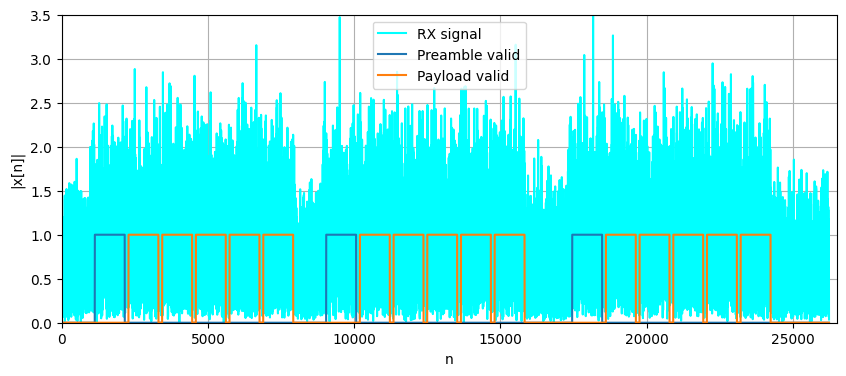

In [19]:
delays = [1000, 1500, 2000]
tx_signal = []
preamble_valid = []
payload_valid = []
for d in delays:
    Z = np.zeros(d)
    frame, pream_valid, pay_valid = createFrame_withSyncInfo(ofdm)
    tx_signal.extend([frame, Z]); preamble_valid.extend([pream_valid, Z]); payload_valid.extend([pay_valid, Z])

tx_signal = np.hstack(tx_signal); preamble_valid = np.hstack(preamble_valid); payload_valid = np.hstack(payload_valid)

plt.figure(figsize=(10, 4))
rx_signal = addNoise(addSTO(tx_signal, sto), 0.5)
preamble_valid = addSTO(preamble_valid, sto)
payload_valid = addSTO(payload_valid, sto)
plt.plot(abs(rx_signal), color='cyan', label='RX signal');
plt.plot(preamble_valid, label='Preamble valid')
plt.plot(payload_valid, label='Payload valid')
plt.axis([0, 26500, 0, 3.5])
plt.ylabel('|x[n]|')
plt.xlabel('n')
plt.legend()
plt.grid(True)
plt.show()


Now, the objective is to create a function that reconstructs the synchronization information solely from the received signal. To do so, first compute the metric and plot it onto the preamble_valid metric plot.

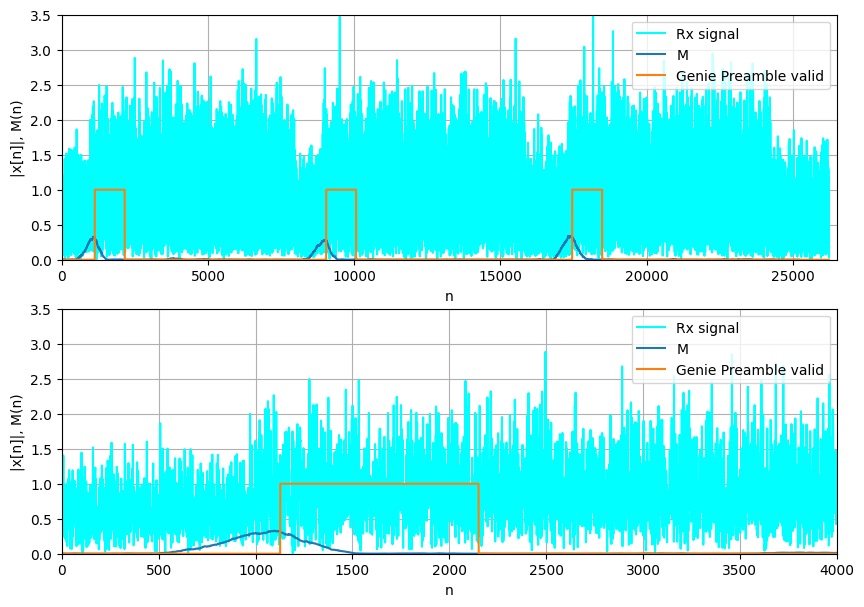

In [20]:
P, R, M = calP_R_M(rx_signal, ofdm.L)

plt.figure(figsize=(10, 7))

# Plot 1: Entire range of samples
plt.subplot(211)
plt.plot(abs(rx_signal), label='Rx signal', color='cyan')
plt.plot(abs(M), label='M')
plt.plot(preamble_valid, label='Genie Preamble valid')
plt.axis([0, 26500, 0, 3.5])
plt.ylabel('|x[n]|, M(n)')
plt.xlabel('n')
plt.legend(loc='upper right')
plt.grid(True)

# Plot 2: First 5000 samples
plt.subplot(212)
plt.plot(abs(rx_signal[:5000]), label='Rx signal', color='cyan')
plt.plot(abs(M[:5000]), label='M')
plt.plot(preamble_valid[:5000], label='Genie Preamble valid')
plt.axis([0, 4000, 0, 3.5])
plt.ylabel('|x[n]|, M(n)')
plt.xlabel('n')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()


As observed in the zoomed-in version, the genie preamble-valid signal transitions to true at the end of the metric's plateau. Therefore, we need to write an algorithm to identify the plateau's end. Given that the plateau's width equals the size of the cyclic prefix (CP), one approach to transform the plateau into a peak is to perform a matched filtering operation using a rectangle with a width equivalent to that of the plateau.

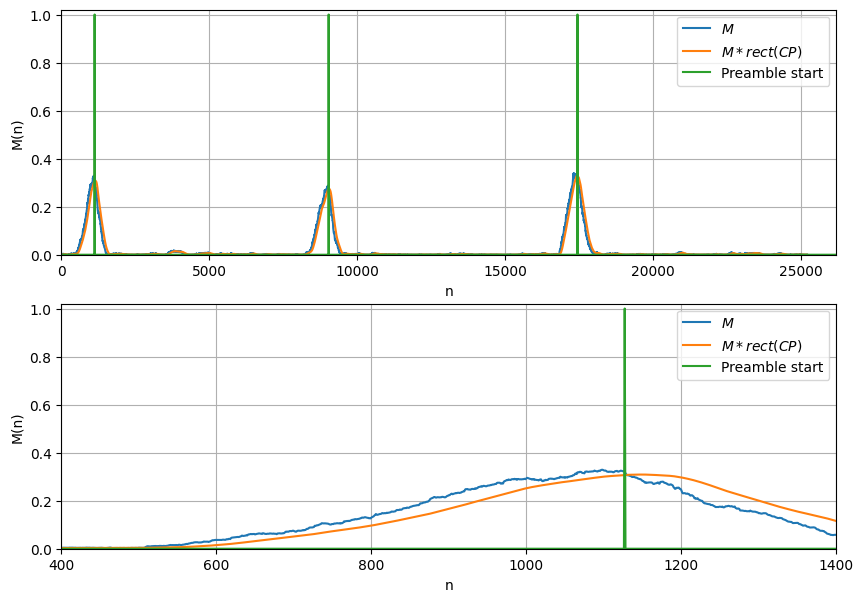

In [21]:
b_to_Peak = np.ones(ofdm.CP)/ofdm.CP
a = (1,)
M_filt = scipy.signal.lfilter(b_to_Peak, a, M)
xlim = (0, 20000)

preamble_start = np.diff(preamble_valid) == 1  # Calculate a flag indicating the start of the preamble

plt.figure(figsize=(10, 7))
plt.subplot(211)
plt.plot(M, label='$M$')
plt.plot(M_filt, label='$M * rect(CP)$')
plt.plot(preamble_start, label='Preamble start')
plt.axis([0, 26200, 0, 1.02])
plt.ylabel('M(n)')
plt.xlabel('n')
plt.legend(loc='upper right')
plt.grid(True)

plt.subplot(212)
plt.plot(M, label='$M$')
plt.plot(M_filt, label='$M * rect(CP)$')
plt.plot(preamble_start, label='Preamble start')
plt.axis([400, 1400, 0, 1.02])
plt.ylabel('M(n)')
plt.xlabel('n')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

Filtering  with a rectangle has two effects: it helps to reduce noise, and it transforms the plateau into a peak, albeit not very prominent. Now, let's proceed with peak detection on the green line. As we know, a peak in a curve corresponds to a zero in its derivative. So, let's examine the derivative.

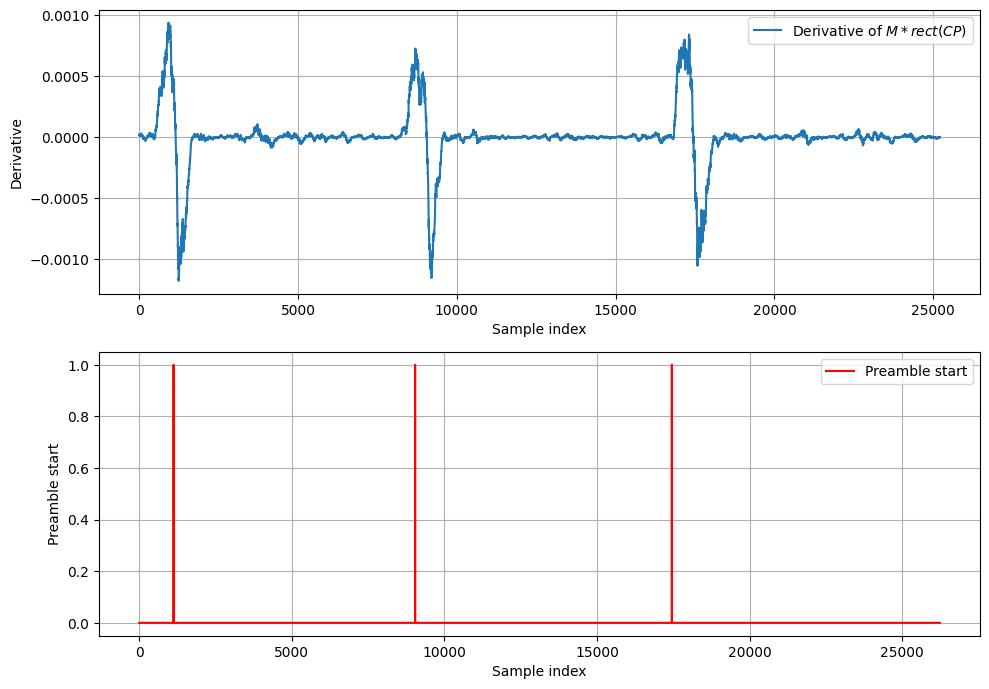

In [22]:
D = np.diff(M_filt)

plt.figure(figsize=(10, 7))

# Plot 1: Derivative plot
plt.subplot(211)
plt.plot(D, label='Derivative of $M*rect(CP)$')
plt.xlabel('Sample index')
plt.ylabel('Derivative')
plt.legend()
plt.grid(True)

# Plot 2: Preamble start points
plt.subplot(212)
plt.plot(preamble_start, label='Preamble start', color='r')
plt.xlabel('Sample index')
plt.ylabel('Preamble start')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


From the above figure, the derivative is zero where the preamble starts. Let's further investigate and detect the zero-crossings of the derivative. The zero-crossings of a signal are determined by a sign change of adjacent samples, hence the product of two adjacent samples should be negative.

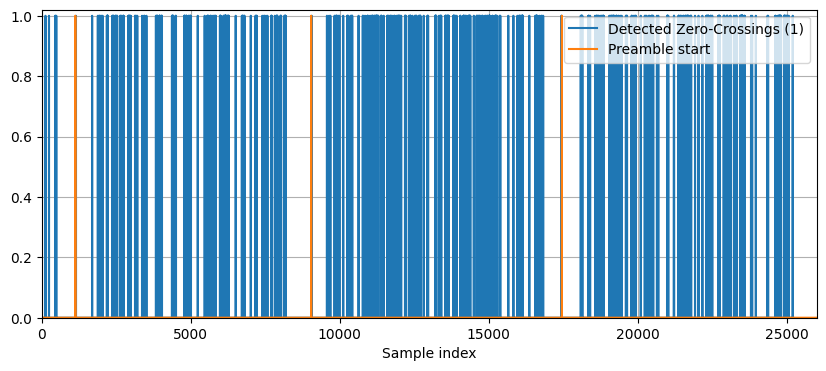

In [23]:
zeroCrossing_1 = (D[:-1] * D[1:]) <= 0

plt.figure(figsize=(10, 4))
plt.plot(zeroCrossing_1, label='Detected Zero-Crossings (1)')
plt.plot(preamble_start, label='Preamble start')
plt.axis([0, 26000, 0, 1.02])
plt.xlabel('Sample index')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

There are a lot of erroneous zero-crossings detected. When the metric is small (i.e. there is no preamble), there is only noise on the preamble, and a lot of zero-crossings happen. So, let's Detect the zero-crossings, where the metric goes beyond a certain threshold.

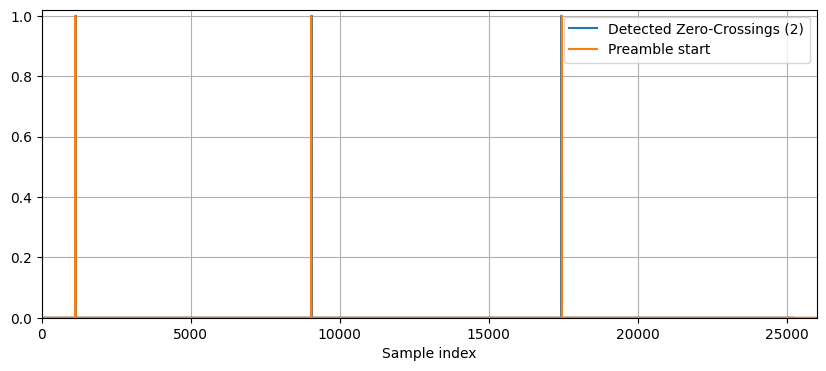

In [24]:
zeroCrossing_2 = ((D[:-1] * D[1:]) <= 0) * (M[1:-1] > 0.1)

plt.figure(figsize=(10, 4))
plt.plot(zeroCrossing_2, label='Detected Zero-Crossings (2)')
plt.plot(preamble_start, label='Preamble start')
plt.axis([0, 26000, 0, 1.02])
plt.xlabel('Sample index')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

This looks much better. Now let's zoom into one preamble start to examine a bit more in detail how the detected zero-crossings look.

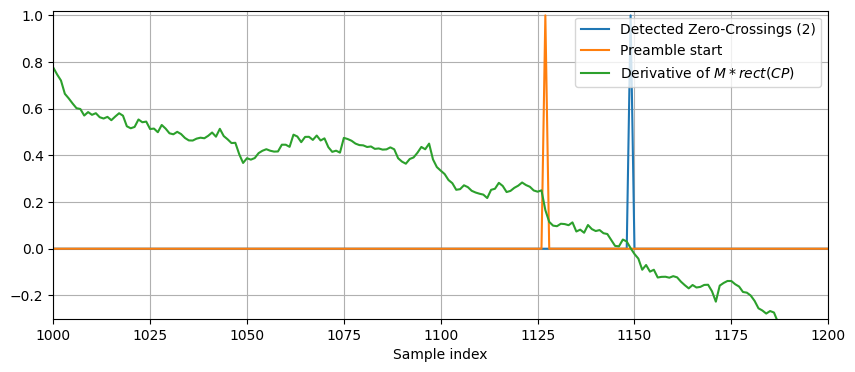

In [25]:
zeroCrossing_2 = ((D[:-1] * D[1:]) <= 0) * (M[1:-1] > 0.1)

plt.figure(figsize=(10, 4))
plt.plot(zeroCrossing_2, label='Detected Zero-Crossings (2)')
plt.plot(preamble_start, label='Preamble start')
plt.plot(D*1000, label='Derivative of $M*rect(CP)$')
plt.axis([1000, 1200, -0.3, 1.02])
plt.xlabel('Sample index')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

It seems that multiple zero-crossings have been detected, which is evident from the derivative having several zero-crossings. Additionally, the positions of the detected zero-crossings do not precisely match the expected locations. Instead, they seem to appear a few samples before the correct starting point. However, this discrepancy isn't problematic because the OFDM symbol incorporates a cyclic prefix (CP), making it resilient against minor timing misalignments.

To address this issue, let's attempt to eliminate the multiple peaks and retain only the first sample. The approach is to disregard all detected zero-crossings except the first one within a range of K+CP samples.

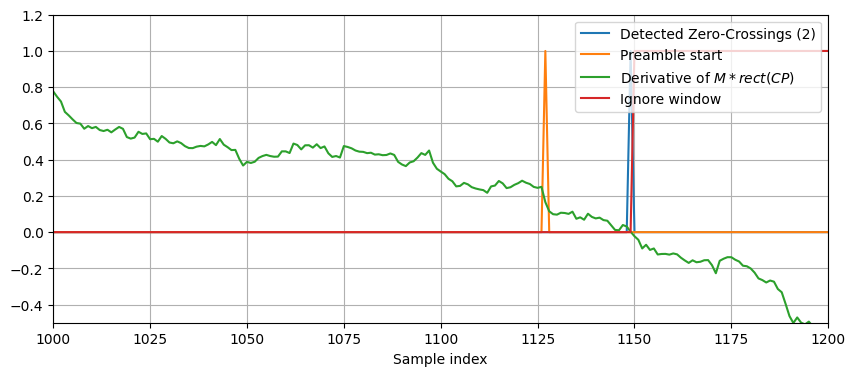

In [26]:
# create a rect window that remains switched on as for the length of the symbol
b_ignore = np.ones(1+ofdm.K+ofdm.CP); b_ignore[0] = 0;  
ignore_times = (scipy.signal.lfilter(b_ignore, (1, ), zeroCrossing_2) > 0).astype(int)

plt.figure(figsize=(10, 4))
plt.plot(zeroCrossing_2, label='Detected Zero-Crossings (2)')
plt.plot(preamble_start, label='Preamble start')
plt.plot(D*1000, label='Derivative of $M*rect(CP)$')
plt.plot(ignore_times, label='Ignore window')
plt.axis([1000, 1200, -0.5, 1.2])
plt.xlabel('Sample index')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

Now, we delete all detected zero-crossings when the ignore-window is non-zero.

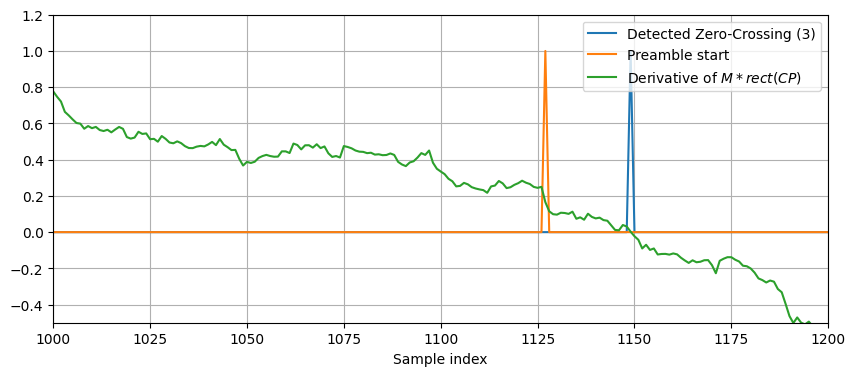

In [27]:
zeroCrossing_3 = zeroCrossing_2 * (ignore_times == 0)   # keep only the zero-crossings where the ignore-window is not on

plt.figure(figsize=(10, 4))
plt.plot(zeroCrossing_3, label='Detected Zero-Crossing (3)')
plt.plot(preamble_start, label='Preamble start')
plt.plot(D*1000, label='Derivative of $M*rect(CP)$')
plt.axis([1000, 1200, -0.5, 1.2])
plt.xlabel('Sample index')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

Now that we've isolated the first zero-crossing and obtained an estimate of the preamble start. Now, we extrac the OFDM symbols and preamble from the received signal stream. We can accomplish this by employing a Finite Impulse Response (FIR) filter that characterizes the structure of the frame.

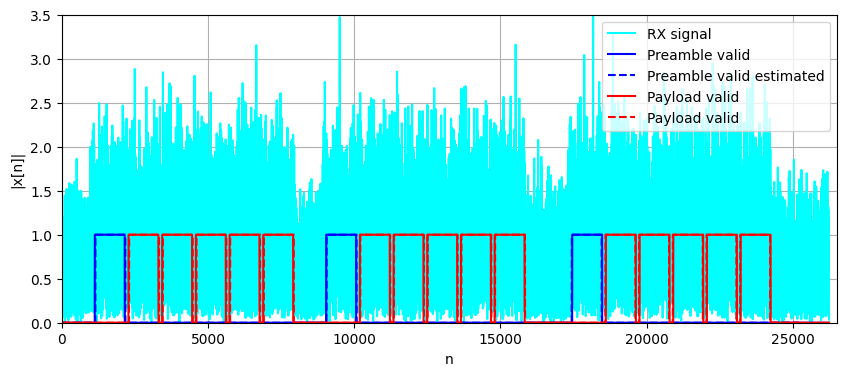

In [28]:
b_preamble = np.zeros(ofdm.K+ofdm.ofdmSymbolsPerFrame*(ofdm.K+ofdm.CP))
b_preamble[:ofdm.K] = 1

b_payload = np.zeros(ofdm.K + ofdm.ofdmSymbolsPerFrame*(ofdm.K+ofdm.CP))
for s in range(ofdm.ofdmSymbolsPerFrame):
    b_payload[ofdm.K + (s+1)*ofdm.CP + s*ofdm.K + np.arange(ofdm.K)] = 1
    
preamble_valid_est = scipy.signal.lfilter(b_preamble, (1,), zeroCrossing_3)
payload_valid_est = scipy.signal.lfilter(b_payload, (1,), zeroCrossing_3)

plt.figure(figsize=(10, 4))
plt.plot(abs(rx_signal), color='cyan', label='RX signal');
plt.plot(preamble_valid, label='Preamble valid', color='blue')
plt.plot(preamble_valid_est, label='Preamble valid estimated', color='blue', ls='--')
plt.plot(payload_valid, label='Payload valid', color='r')
plt.plot(payload_valid_est, label='Payload valid', color='r', ls='--')
plt.axis([0, 26500, 0, 3.5])
plt.xlabel('n')
plt.ylabel('|x[n]|')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

OFDM payload symbols have been successfully extracted, excluding the cyclic prefix (CP). The estimated frame position closely aligns with the exact positions of the symbols. With the cyclic prefix, minor timing offsets are not problematic.